# 分析思路
* 为达到广告精准投放的效果，分别从三方面分析确定：
1. 广告投放渠道
2. 广告投放时间
3. 广告投放目标人群
* 根据三个方面的不同广告投放效果（1.以页面访问占比，即点击率为指标衡量广告投放效果（CPC相关）；2.以用户行为为指标衡量广告投放效果（CPA相关）），找出实现广告精准投放的方案。首先，分析CPC相关。

## 1. 数据导入

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('data/raw_sample.csv')
df.head()

,user,time_stamp,adgroup_id,pid,nonclk,clk
0,581738,1494137644,1,430548_1007,1,0
1,449818,1494638778,3,430548_1007,1,0
2,914836,1494650879,4,430548_1007,1,0
3,914836,1494651029,5,430548_1007,1,0
4,399907,1494302958,8,430548_1007,1,0


In [3]:
df.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26557961 entries, 0 to 26557960
Data columns (total 6 columns):
 #   Column      Non-Null Count     Dtype 
---  ------      --------------     ----- 
 0   user        26557961 non-null  int64 
 1   time_stamp  26557961 non-null  int64 
 2   adgroup_id  26557961 non-null  int64 
 3   pid         26557961 non-null  object
 4   nonclk      26557961 non-null  int64 
 5   clk         26557961 non-null  int64 
dtypes: int64(5), object(1)
memory usage: 1.2+ GB


In [4]:
users = pd.read_csv('data/user_profile.csv')
users.head()

,userid,cms_segid,cms_group_id,final_gender_code,age_level,pvalue_level,shopping_level,occupation,new_user_class_level
0,234,0,5,2,5,NaN,3,0,3.0
1,523,5,2,2,2,1.0,3,1,2.0
2,612,0,8,1,2,2.0,3,0,NaN
3,1670,0,4,2,4,NaN,1,0,NaN
4,2545,0,10,1,4,NaN,3,0,NaN


In [5]:
users.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1061768 entries, 0 to 1061767
Data columns (total 9 columns):
 #   Column                 Non-Null Count    Dtype  
---  ------                 --------------    -----  
 0   userid                 1061768 non-null  int64  
 1   cms_segid              1061768 non-null  int64  
 2   cms_group_id           1061768 non-null  int64  
 3   final_gender_code      1061768 non-null  int64  
 4   age_level              1061768 non-null  int64  
 5   pvalue_level           485851 non-null   float64
 6   shopping_level         1061768 non-null  int64  
 7   occupation             1061768 non-null  int64  
 8   new_user_class_level   716848 non-null   float64
dtypes: float64(2), int64(7)
memory usage: 72.9 MB


In [6]:
ad = pd.read_csv('data/ad_feature.csv')
ad.head()

,adgroup_id,cate_id,campaign_id,customer,brand,price
0,63133,6406,83237,1,95471.0,170.00
1,313401,6406,83237,1,87331.0,199.00
2,248909,392,83237,1,32233.0,38.00
3,208458,392,83237,1,174374.0,139.00
4,110847,7211,135256,2,145952.0,32.99


In [7]:
ad.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 846811 entries, 0 to 846810
Data columns (total 6 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   adgroup_id   846811 non-null  int64  
 1   cate_id      846811 non-null  int64  
 2   campaign_id  846811 non-null  int64  
 3   customer     846811 non-null  int64  
 4   brand        600481 non-null  float64
 5   price        846811 non-null  float64
dtypes: float64(2), int64(4)
memory usage: 38.8 MB


## 2. 数据预处理
### 2.1 重复值处理

In [8]:
df[df.duplicated()].sort_values(by='user')

,user,time_stamp,adgroup_id,pid,nonclk,clk


* 说明没有重复数据

In [9]:
# df.drop_duplicates(inplace=True)
# df.reset_index(drop=True, inplace=True)
# df.info()

* 原始样本骨架raw_sample无重复值和缺失值

In [10]:
users.drop_duplicates(inplace=True)
users.reset_index(drop=True, inplace=True)
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1061768 entries, 0 to 1061767
Data columns (total 9 columns):
 #   Column                 Non-Null Count    Dtype  
---  ------                 --------------    -----  
 0   userid                 1061768 non-null  int64  
 1   cms_segid              1061768 non-null  int64  
 2   cms_group_id           1061768 non-null  int64  
 3   final_gender_code      1061768 non-null  int64  
 4   age_level              1061768 non-null  int64  
 5   pvalue_level           485851 non-null   float64
 6   shopping_level         1061768 non-null  int64  
 7   occupation             1061768 non-null  int64  
 8   new_user_class_level   716848 non-null   float64
dtypes: float64(2), int64(7)
memory usage: 72.9 MB


* 用户基本信息表user_profile无重复值

In [11]:
ad.drop_duplicates(inplace=True)
ad.reset_index(drop=True, inplace=True)
ad.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 846811 entries, 0 to 846810
Data columns (total 6 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   adgroup_id   846811 non-null  int64  
 1   cate_id      846811 non-null  int64  
 2   campaign_id  846811 non-null  int64  
 3   customer     846811 non-null  int64  
 4   brand        600481 non-null  float64
 5   price        846811 non-null  float64
dtypes: float64(2), int64(4)
memory usage: 38.8 MB


* 广告基本信息表ad_feature无重复值

### 2.2 缺失值处理

In [12]:
users.replace(np.nan, '数据缺失', inplace=True)
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1061768 entries, 0 to 1061767
Data columns (total 9 columns):
 #   Column                 Non-Null Count    Dtype 
---  ------                 --------------    ----- 
 0   userid                 1061768 non-null  int64 
 1   cms_segid              1061768 non-null  int64 
 2   cms_group_id           1061768 non-null  int64 
 3   final_gender_code      1061768 non-null  int64 
 4   age_level              1061768 non-null  int64 
 5   pvalue_level           1061768 non-null  object
 6   shopping_level         1061768 non-null  int64 
 7   occupation             1061768 non-null  int64 
 8   new_user_class_level   1061768 non-null  object
dtypes: int64(7), object(2)
memory usage: 72.9+ MB


In [13]:
ad.replace(np.nan, '数据缺失', inplace=True)
ad.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 846811 entries, 0 to 846810
Data columns (total 6 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   adgroup_id   846811 non-null  int64  
 1   cate_id      846811 non-null  int64  
 2   campaign_id  846811 non-null  int64  
 3   customer     846811 non-null  int64  
 4   brand        846811 non-null  object 
 5   price        846811 non-null  float64
dtypes: float64(1), int64(4), object(1)
memory usage: 38.8+ MB


## 3. 数据分析
### 3.1 广告投放渠道分析

In [14]:
clk_per = df.clk.sum()/df.shape[0] * 100
print('总页面访问占比（点击率）为：', clk_per, '%')

总页面访问占比（点击率）为： 5.143678010521968 %


<AxesSubplot:xlabel='pid', ylabel='clk'>

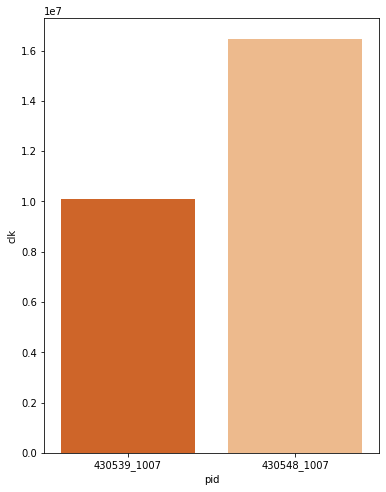

In [15]:
plt.figure(figsize=(6,8))
# x轴为资源位
y = df.groupby(by=['pid'])['clk'].size()
x = y.index
sns.barplot(x, y, palette='Oranges_r')

* 资源位430539_1007的点击率低于430548_1007

### 3.2 广告投放时间

In [16]:
df['hour'] = pd.to_datetime(df['time_stamp'], unit='s').dt.hour
df['hour'] = df.hour.astype('str')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26557961 entries, 0 to 26557960
Data columns (total 7 columns):
 #   Column      Dtype 
---  ------      ----- 
 0   user        int64 
 1   time_stamp  int64 
 2   adgroup_id  int64 
 3   pid         object
 4   nonclk      int64 
 5   clk         int64 
 6   hour        object
dtypes: int64(5), object(2)
memory usage: 1.4+ GB


<AxesSubplot:xlabel='hour', ylabel='clk'>

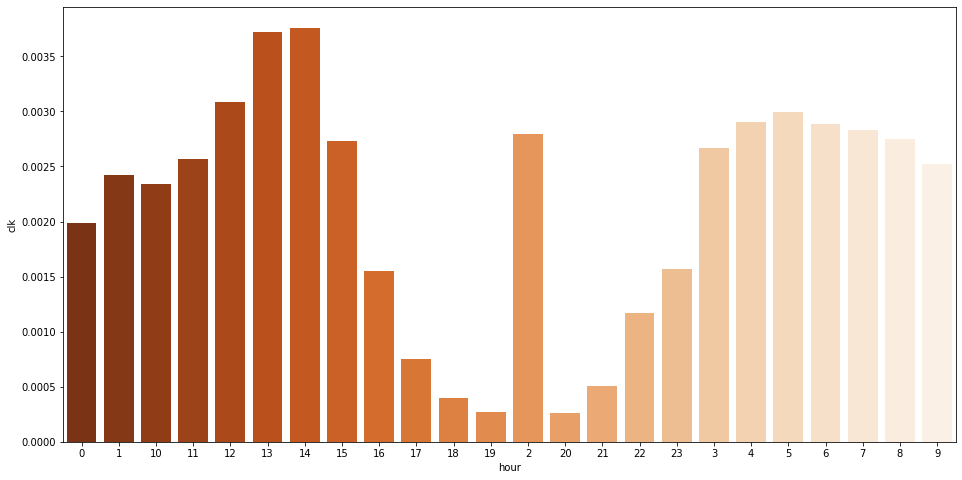

In [17]:
plt.figure(figsize=(16,8))
y = df.groupby(by=['hour'])['clk'].sum()/df.shape[0]
x = y.index
sns.barplot(x, y, palette='Oranges_r')

* 12-15时的广告点击率相对较高，18-21时的点击率极低。当然，点击率的高低对比也受各时间段的浏览量影响，点击率低的时间段有可能由于高浏览量造成，点击率高的时间段也有可能是由于低浏览量造成的。具体情况还需要更多数据进一步分析。

In [18]:
df['weekday'] = pd.to_datetime(df['time_stamp'], unit='s').dt.weekday
df['weekday'] = df.weekday.astype('str')
df.head()

,user,time_stamp,adgroup_id,pid,nonclk,clk,hour,weekday
0,581738,1494137644,1,430548_1007,1,0,6,6
1,449818,1494638778,3,430548_1007,1,0,1,5
2,914836,1494650879,4,430548_1007,1,0,4,5
3,914836,1494651029,5,430548_1007,1,0,4,5
4,399907,1494302958,8,430548_1007,1,0,4,1


<AxesSubplot:xlabel='weekday', ylabel='clk'>

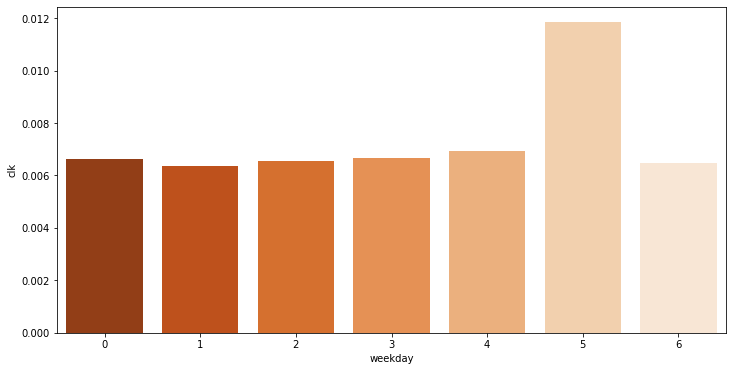

In [19]:
plt.figure(figsize=(12,6))
y = df.groupby(by=['weekday'])['clk'].sum()/df.shape[0]
x = y.index
sns.barplot(x, y, palette='Oranges_r')

* 周六点击率最高，其余时间的点击率很接近。周六的广告投放效果最好

### 3.3 广告投放目标人群（有点击行为的用户特征）
* 连接user_profile和raw_sample两表，筛选出有点击广告行为的用户

In [20]:
df.set_index(['user'], inplace=True)
df.head()

,time_stamp,adgroup_id,pid,nonclk,clk,hour,weekday
user,,,,,,,
581738,1494137644,1,430548_1007,1,0,6,6
449818,1494638778,3,430548_1007,1,0,1,5
914836,1494650879,4,430548_1007,1,0,4,5
914836,1494651029,5,430548_1007,1,0,4,5
399907,1494302958,8,430548_1007,1,0,4,1


In [22]:
users.head()

,userid,cms_segid,cms_group_id,final_gender_code,age_level,pvalue_level,shopping_level,occupation,new_user_class_level
0,234,0,5,2,5,数据缺失,3,0,3
1,523,5,2,2,2,1,3,1,2
2,612,0,8,1,2,2,3,0,数据缺失
3,1670,0,4,2,4,数据缺失,1,0,数据缺失
4,2545,0,10,1,4,数据缺失,3,0,数据缺失


In [23]:
user_ac = pd.merge(df, users, right_on='userid', left_index=True, how='outer')

In [24]:
user_ac.replace('数据缺失', np.nan, inplace=True)
user_ac.clk.replace(0, np.nan, inplace=True)
user_ac.dropna(inplace=True)
user_ac.info()

<class 'pandas.core.frame.DataFrame'>
Float64Index: 520673 entries, 882433.0 to 29744.0
Data columns (total 16 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   time_stamp             520673 non-null  int64  
 1   adgroup_id             520673 non-null  int64  
 2   pid                    520673 non-null  object 
 3   nonclk                 520673 non-null  int64  
 4   clk                    520673 non-null  float64
 5   hour                   520673 non-null  object 
 6   weekday                520673 non-null  object 
 7   userid                 520673 non-null  int64  
 8   cms_segid              520673 non-null  float64
 9   cms_group_id           520673 non-null  float64
 10  final_gender_code      520673 non-null  float64
 11  age_level              520673 non-null  float64
 12  pvalue_level           520673 non-null  float64
 13  shopping_level         520673 non-null  float64
 14  occupation             520

In [25]:
user_ac

,time_stamp,adgroup_id,pid,nonclk,clk,hour,weekday,userid,cms_segid,cms_group_id,final_gender_code,age_level,pvalue_level,shopping_level,occupation,new_user_class_level
882433.0,1494249343,497412,430548_1007,0,1.0,13,0,623911,93.0,11.0,1.0,5.0,3.0,3.0,0.0,2.0
882433.0,1494507951,86117,430548_1007,0,1.0,13,3,623911,93.0,11.0,1.0,5.0,3.0,3.0,0.0,2.0
498395.0,1494202050,331871,430548_1007,0,1.0,0,0,976358,20.0,3.0,2.0,3.0,2.0,3.0,0.0,4.0
498395.0,1494202050,275091,430548_1007,0,1.0,0,0,976358,20.0,3.0,2.0,3.0,2.0,3.0,0.0,4.0
647944.0,1494257273,311477,430539_1007,0,1.0,15,0,286630,17.0,3.0,2.0,3.0,1.0,3.0,0.0,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
420811.0,1494650559,836654,430548_1007,0,1.0,4,5,185132,2.0,1.0,2.0,1.0,1.0,3.0,0.0,4.0
908867.0,1494459308,836889,430539_1007,0,1.0,23,2,75643,6.0,2.0,2.0,2.0,2.0,2.0,0.0,3.0
1055455.0,1494460513,836889,430548_1007,0,1.0,23,2,861171,8.0,2.0,2.0,2.0,2.0,3.0,0.0,3.0
520366.0,1494564990,836889,430539_1007,0,1.0,4,4,791084,19.0,3.0,2.0,3.0,2.0,3.0,1.0,2.0


#### a.用户性别

<AxesSubplot:xlabel='final_gender_code'>

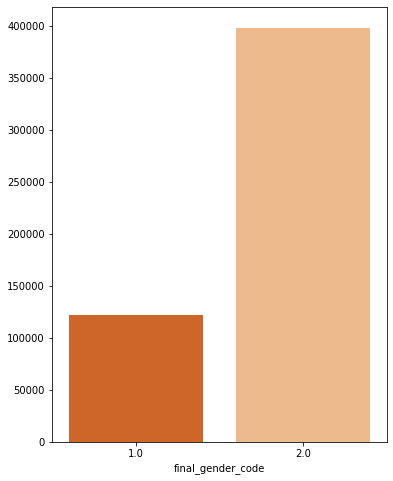

In [26]:
plt.figure(figsize=(6,8))
x = user_ac.groupby(by=['final_gender_code']).size().index
y = user_ac.groupby(by=['final_gender_code']).size()
sns.barplot(x, y, palette='Oranges_r')

* 1代表男性，2代表女性，男性的广告点击率低于女性。

#### b.消费档次

<AxesSubplot:xlabel='pvalue_level'>

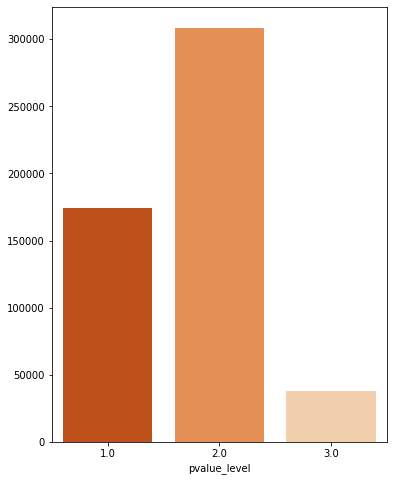

In [27]:
plt.figure(figsize=(6,8))
x = user_ac.groupby(by=['pvalue_level']).size().index
y = user_ac.groupby(by=['pvalue_level']).size()
sns.barplot(x, y, palette='Oranges_r')

* 中档消费档次的点击率最高，其次是低档，最低是高档。

#### c.购物深度

<AxesSubplot:xlabel='shopping_level'>

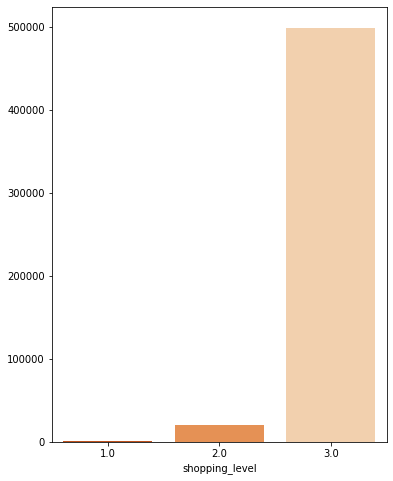

In [28]:
plt.figure(figsize=(6,8))
x = user_ac.groupby(by=['shopping_level']).size().index
y = user_ac.groupby(by=['shopping_level']).size()
sns.barplot(x, y, palette='Oranges_r')

* 说明随着购物深度的增加，用户打开广告的欲望越强，深层用户更容易被广告吸引。

#### d.是否是大学生

<AxesSubplot:xlabel='occupation'>

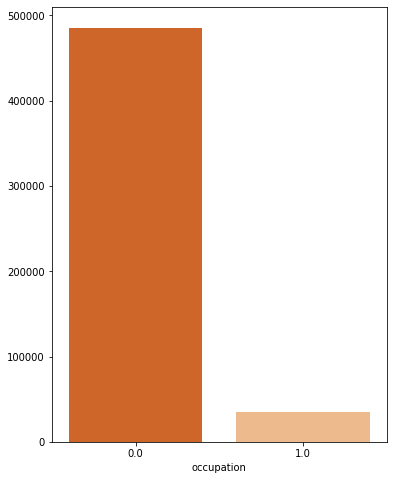

In [29]:
plt.figure(figsize=(6,8))
x = user_ac.groupby(by=['occupation']).size().index
y = user_ac.groupby(by=['occupation']).size()
sns.barplot(x, y, palette='Oranges_r')

* 广告对大学生吸引较小，非大学生更容易被广告吸引，点击广告。

#### e.年龄层次

<AxesSubplot:xlabel='age_level'>

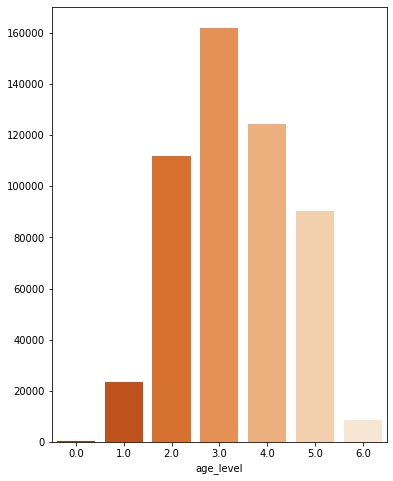

In [30]:
plt.figure(figsize=(6,8))
x = user_ac.groupby(by=['age_level']).size().index
y = user_ac.groupby(by=['age_level']).size()
sns.barplot(x, y, palette='Oranges_r')

* 广告点击的年龄层次主要集中在2,3,4,5，而0,1,6年龄段很难被广告吸引。

## 结论
1. 渠道：430548_1007渠道的广告投放效果要好于430539_1007。
2. 时间：12-14时的广告点击率较高，且周六的广告投放效果最好。
3. 用户：女性，低中档的消费档次，深层购物深度，非大学生，年龄层次在2,3,4,5的用户点击意愿更强。


### 上述分析是基于点击率为指标对比广告效果（CPC相关），如果按用户点击后的行为来作为指标对比广告效果，包括加入购物车率，收藏率和购买率，(CPA相关)，做一个各阶段转化率的简单分析。
* 用户在点击广告浏览后，加入购物车的转化率约为2.5%，购买转化率约1.4%，和点击浏览广告后加入收藏的转化率（1.46%）接近。如果是选择CPA作为广告收费计算方式，需要提高用户的加入购物车转化率，购买转化率和收藏转化率。这三个转化率低，是用户在点击广告进入商品详情界面，即着落页后，较难激发购物欲望，说明着落页需要优化，才可以提高转化率，优化广告投放效果。